In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix
import numpy as np
import shutil

plt.ion()   # interactive mode

In [72]:
actionTags = os.listdir("/home/jack/Desktop/Datasets/ADL_varRP/train/")
print actionTags

['Drink_glass', 'Walk', 'Getup_bed', 'Sitdown_chair', 'Pour_water', 'Standup_chair', 'Climb_stairs']


In [70]:
#restore val to train
for action in actionTags:
    filelist = os.listdir("/home/jack/Desktop/Datasets/ADL_varRP/val/"+action)
    for item in filelist:
        shutil.move("/home/jack/Desktop/Datasets/ADL_varRP/val/"+action+"/"+item, 
            "/home/jack/Desktop/Datasets/ADL_varRP/train/"+action+"/"+item)

In [73]:
#split train and val
for action in actionTags:
    filelist = os.listdir("/home/jack/Desktop/Datasets/ADL_varRP/train/"+action)
    for item in filelist:
        if np.random.uniform() < 0.3:
            shutil.move("/home/jack/Desktop/Datasets/ADL_varRP/train/"+action+"/"+item, 
            "/home/jack/Desktop/Datasets/ADL_varRP/val/"+action+"/"+item)

In [74]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/home/jack/Downloads/hymenoptera_data'
data_dir = '/home/jack/Desktop/Datasets/ADL_varRP'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

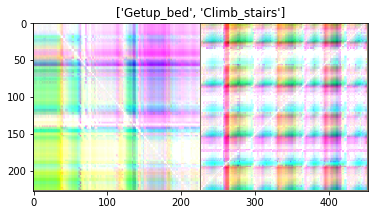

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [76]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = []
    best_labels = []
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        total_npy_preds = []
        total_npy_labels = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:

                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                
                #confusion matrix
                npy_preds = preds.cpu().numpy()
                npy_labels = labels.data.cpu().numpy() 
                total_npy_preds = np.append(total_npy_preds,npy_preds) 
                total_npy_labels = np.append(total_npy_labels,npy_labels)
                
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            print epoch_acc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = total_npy_preds
                best_labels = total_npy_labels

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    cm = confusion_matrix(best_labels, best_preds)
    print('Confusion Matrix:', cm)
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,cm

In [77]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]], labels[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [78]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [79]:
model_ft, cm = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
0.329268292683
train Loss: 2.0447 Acc: 0.3293
0.680203045685
val Loss: 1.3383 Acc: 0.6802
Epoch 1/99
----------
0.434959349593
train Loss: 1.7543 Acc: 0.4350
0.634517766497
val Loss: 1.5007 Acc: 0.6345
Epoch 2/99
----------
0.526422764228
train Loss: 1.5176 Acc: 0.5264
0.720812182741
val Loss: 0.9465 Acc: 0.7208
Epoch 3/99
----------
0.483739837398
train Loss: 1.7046 Acc: 0.4837
0.802030456853
val Loss: 0.5816 Acc: 0.8020
Epoch 4/99
----------
0.526422764228
train Loss: 1.4627 Acc: 0.5264
0.817258883249
val Loss: 0.6625 Acc: 0.8173
Epoch 5/99
----------
0.532520325203
train Loss: 1.4932 Acc: 0.5325
0.781725888325
val Loss: 0.6674 Acc: 0.7817
Epoch 6/99
----------
0.569105691057
train Loss: 1.2969 Acc: 0.5691
0.832487309645
val Loss: 0.5117 Acc: 0.8325
Epoch 7/99
----------
0.69918699187
train Loss: 0.9356 Acc: 0.6992
0.878172588832
val Loss: 0.4319 Acc: 0.8782
Epoch 8/99
----------
0.74593495935
train Loss: 0.8530 Acc: 0.7459
0.878172588832
val Loss: 0.3828 Acc: 0

0.772357723577
train Loss: 0.7455 Acc: 0.7724
0.903553299492
val Loss: 0.3752 Acc: 0.9036
Epoch 74/99
----------
0.792682926829
train Loss: 0.7353 Acc: 0.7927
0.89847715736
val Loss: 0.3851 Acc: 0.8985
Epoch 75/99
----------
0.737804878049
train Loss: 0.8158 Acc: 0.7378
0.903553299492
val Loss: 0.3438 Acc: 0.9036
Epoch 76/99
----------
0.766260162602
train Loss: 0.7879 Acc: 0.7663
0.903553299492
val Loss: 0.3449 Acc: 0.9036
Epoch 77/99
----------
0.768292682927
train Loss: 0.7929 Acc: 0.7683
0.893401015228
val Loss: 0.3743 Acc: 0.8934
Epoch 78/99
----------
0.784552845528
train Loss: 0.7265 Acc: 0.7846
0.89847715736
val Loss: 0.3890 Acc: 0.8985
Epoch 79/99
----------
0.792682926829
train Loss: 0.7516 Acc: 0.7927
0.883248730964
val Loss: 0.3653 Acc: 0.8832
Epoch 80/99
----------
0.758130081301
train Loss: 0.7703 Acc: 0.7581
0.908629441624
val Loss: 0.3475 Acc: 0.9086
Epoch 81/99
----------
0.762195121951
train Loss: 0.7564 Acc: 0.7622
0.913705583756
val Loss: 0.3960 Acc: 0.9137
Epoch 82

In [80]:
normalized_cm = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        normalized_cm[i][j] = float(cm[i][j])/sum(cm[i])
print normalized_cm

[[0.78431373 0.         0.03921569 0.00980392 0.00980392 0.01960784
  0.1372549 ]
 [0.         0.89583333 0.04166667 0.04166667 0.01041667 0.
  0.01041667]
 [0.00990099 0.02970297 0.75247525 0.04950495 0.03960396 0.08910891
  0.02970297]
 [0.         0.07       0.1        0.82       0.         0.
  0.01      ]
 [0.         0.04166667 0.05208333 0.03125    0.84375    0.02083333
  0.01041667]
 [0.         0.02105263 0.10526316 0.02105263 0.03157895 0.8
  0.02105263]
 [0.08080808 0.         0.02020202 0.01010101 0.01010101 0.02020202
  0.85858586]]


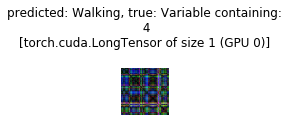

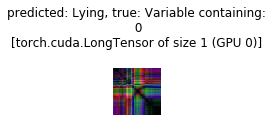

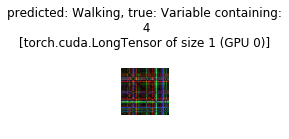

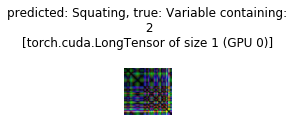

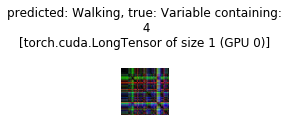

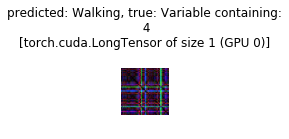

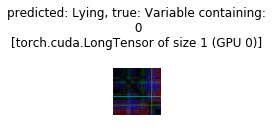

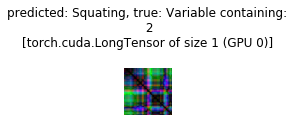

In [27]:
visualize_model(model_ft)

In [28]:
torch.save(model_ft, 'model_rawNormalizedRPXYZ_Resnet.pkl')
torch.save(model_ft.state_dict(), 'model_rawNormalizedRPXYZ_Resnet_params.pkl')